In [2]:
%pip install torch torchvision
%pip install transformers
%pip install diffusers

   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/204.1 MB 7.9 MB/s eta 0:00:26
   ---------------------------------------- 0.5/204.1 MB 6.6 MB/s eta 0:00:32
   ---------------------------------------- 0.6/204.1 MB 5.3 MB/s eta 0:00:39
   ---------------------------------------- 0.9/204.1 MB 5.4 MB/s eta 0:00:38
   ---------------------------------------- 1.3/204.1 MB 5.8 MB/s eta 0:00:36
   ---------------------------------------- 1.6/204.1 MB 6.0 MB/s eta 0:00:34
   ---------------------------------------- 1.9/204.1 MB 6.2 MB/s eta 0:00:33
   ---------------------------------------- 2.3/204.1 MB 6.3 MB/s eta 0:00:33
    --------------------------------------- 2.6/204.1 MB 6.4 MB/s eta 0:00:32
    --------------------------------------- 2.9/204.1 MB 6.4 MB/s eta 0:00:32
    --------------------------------------- 3.3/204.1 MB 6.6 MB/s eta 0:00:31
    --------------------------------------- 3.6/204.1 MB 6.6 MB/s eta 0

Using device: cpu


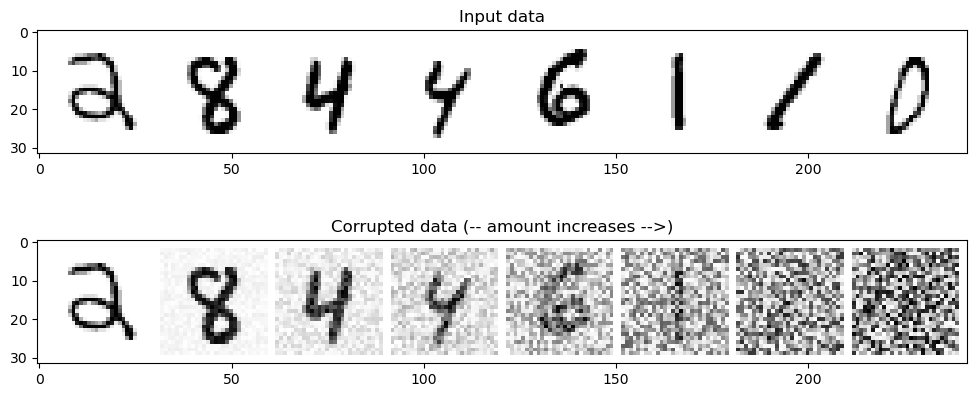

In [3]:
# https://huggingface.co/learn/diffusion-course/en/unit1/3

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))


def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return x * (1 - amount) + noise * amount


# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")



In [ ]:

# class BasicUNet(nn.Module):
#     """A minimal UNet implementation."""

#     def __init__(self, in_channels=1, out_channels=1):
#         super().__init__()
#         self.down_layers = torch.nn.ModuleList(
#             [
#                 nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
#                 nn.Conv2d(32, 64, kernel_size=5, padding=2),
#                 nn.Conv2d(64, 64, kernel_size=5, padding=2),
#             ]
#         )
#         self.up_layers = torch.nn.ModuleList(
#             [
#                 nn.Conv2d(64, 64, kernel_size=5, padding=2),
#                 nn.Conv2d(64, 32, kernel_size=5, padding=2),
#                 nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
#             ]
#         )
#         self.act = nn.SiLU()  # The activation function
#         self.downscale = nn.MaxPool2d(2)
#         self.upscale = nn.Upsample(scale_factor=2)

#     def forward(self, x):
#         h = []
#         for i, l in enumerate(self.down_layers):
#             x = self.act(l(x))  # Through the layer and the activation function
#             if i < 2:  # For all but the third (final) down layer:
#                 h.append(x)  # Storing output for skip connection
#                 x = self.downscale(x)  # Downscale ready for the next layer

#         for i, l in enumerate(self.up_layers):
#             if i > 0:  # For all except the first up layer
#                 x = self.upscale(x)  # Upscale
#                 x += h.pop()  # Fetching stored output (skip connection)
#             x = self.act(l(x))  # Through the layer and the activation function

#         return x


Finished epoch 0. Average loss for this epoch: 0.019902
Finished epoch 1. Average loss for this epoch: 0.012876
Finished epoch 2. Average loss for this epoch: 0.011792


TypeError: UNet2DModel.forward() missing 1 required positional argument: 'timestep'

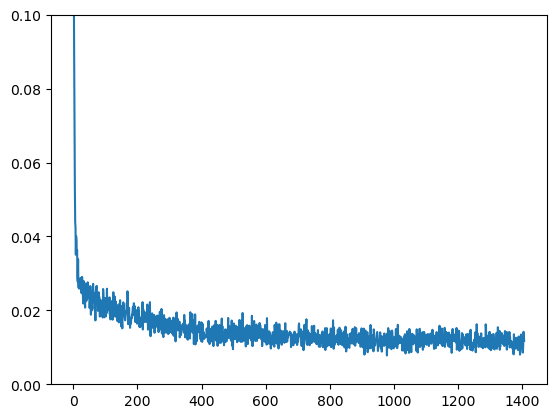

In [ ]:
from diffusers import DDPMScheduler, UNet2DModel

batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)  # <<<
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(
            device)  # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount)  # Create our noisy x

        # Get the model prediction
        # <<< Using timestep 0 always, adding .sample
        pred = net(noisy_x, 0).sample

        # Calculate the loss
        # How close is the output to the true 'clean' x?
        loss = loss_fn(pred, x)

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(
        f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(
        device) * (1 - (i / n_steps))  # Starting high going low
    with torch.no_grad():
        pred = net(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[1].imshow(torchvision.utils.make_grid(
    x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Generated Samples")

plt.show()

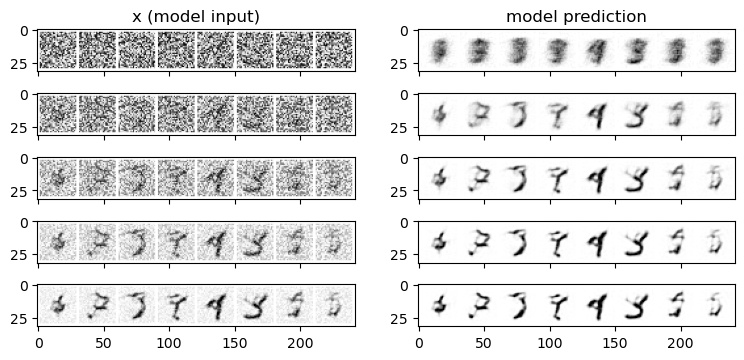

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
# Noise a batch of images to view the effect
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2.0 - 1.0  # Map to (-1, 1)
print("X shape", xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(
    xb[:8])[0].detach().cpu(), cmap="Greys")
axs[0].set_title("Clean X")

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)  # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[
              0].detach().cpu().clip(-1, 1), cmap="Greys")
axs[1].set_title("Noisy X (clipped to (-1, 1)")
axs[2].imshow(torchvision.utils.make_grid(
    noisy_xb[:8])[0].detach().cpu(), cmap="Greys")
axs[2].set_title("Noisy X")

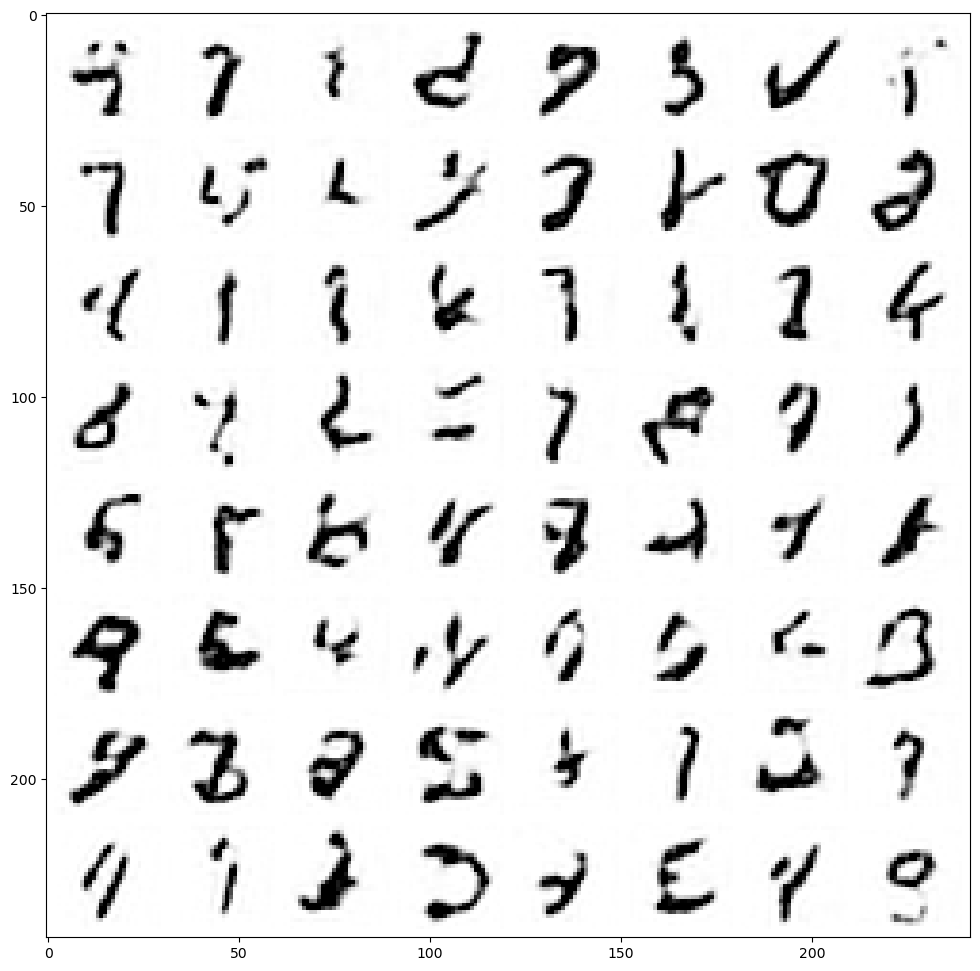

In [14]:
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps))  # Starting high going low
    with torch.no_grad():
        pred = net(x)
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys")
plt.show()